# Testing Tracker updation

## Importing libraries

In [1]:
# -----------------------------
# IMPORTING LIBRARIES
# -----------------------------

import pandas as pd
import os
import sys
from pathlib import Path
from langgraph_flow import *

# -----------------------------
# SETTING UP PATH
# -----------------------------

path = Path(os.path.dirname(os.getcwd()))
path = str(path)
print(path)
sys.path.insert(1, path)

/Users/saideepbunny/Projects/Email-Assistant-using-Generative-AI


## Upsert functions

In [2]:
def upsert_applications(sheet_name, updates_df: pd.DataFrame,
                        overwrite: bool = True):
    """
    Upsert rows from `updates_df` into the Excel 'base' sheet using
    ['company_name','job_title'] as the composite key, then save back
    to the same file/sheet.

    Columns: ['company_name','job_title','job_id','application_status']
    - overwrite=True: replace entire matching rows
    - overwrite=False: update only where incoming has non-null values
    """
    cols = ["company_name", "job_title", "job_id", "application_status"]

    # Read current sheet
    base = read_tracker_file(sheet_name)
    updates_df = updates_df.copy()[cols]

    # If updates_df has duplicate keys, keep the last one
    updates_df = updates_df.drop_duplicates(
        subset=["company_name", "job_title"], keep="last"
    )

    # Composite index for clean upsert
    base_i    = base.set_index(["company_name", "job_title"])
    updates_i = updates_df.set_index(["company_name", "job_title"])

    out = base_i.copy()

    # ---- UPDATE (existing keys) ----
    if overwrite:
        common = out.index.intersection(updates_i.index)
        out.loc[common] = updates_i.loc[common]
    else:
        out.update(updates_i)  # only non-null values from updates_df overwrite

    # ---- INSERT (new keys) ----
    new_only = updates_i.index.difference(out.index)
    out = pd.concat([out, updates_i.loc[new_only]], axis=0)

    # Final DataFrame
    out_df = out.reset_index()
    print(out_df)

    # ---- SAVE back to the same file and sheet ----
    # assumes global variable `path` points to the Excel file
    try:
        with pd.ExcelWriter(f"{path}/data/application_tracker.xlsx", engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
            out_df.to_excel(writer, sheet_name=sheet_name, index=False)
        print(f"Updated tracker file at {path}/data/application_tracker.xlsx, sheet: {sheet_name}")
    except FileNotFoundError:
        # If file doesn't exist yet, create it
        with pd.ExcelWriter(f"{path}/data/application_tracker.xlsx", engine="openpyxl", mode="w") as writer:
            out_df.to_excel(writer, sheet_name=sheet_name, index=False)



def read_tracker_file(sheet_name="tracker"):
    """
    Reads the base Excel, normalizes headers, and returns:
    ['company_name','job_title','job_id','application_status']
    """
    # Read (keep job_id as string so leading zeros aren’t lost)
    df = pd.read_excel(f"{path}/data/application_tracker.xlsx", sheet_name=sheet_name)

    # Required columns
    cols = ["company_name", "job_title", "job_id", "application_status"]
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns in {Path(path).name}: {missing}")

    # Return only needed columns, drop empty key rows
    return (df[cols]
            .dropna(subset=["company_name"])
            .reset_index(drop=True))


## Test

In [3]:
email1 = """We have received your application for Analyst, Data Science - 2025-71048
Hello Saideep,

Thank you for applying to our Analyst, Data Science position. We’re reviewing your application and will be in touch if your experience is a match for our current needs.
We appreciate your interest in Liberty Mutual Insurance.

Thank you,
Talent Acquisition

 

Replies to this message are undeliverable and will not reach Talent Acquisition. Please do not reply."""

email2 = """Hello Saideep, 
Thank you for your interest in the Analyst, Data Science- 2025-71048 position. After careful review of your application and resume, we have decided to move forward with other applicants whose skills and experience better align with our needs at this time.
To learn about additional career opportunities at Liberty Mutual Insurance, we invite you to join one of our Talent Communities.   
Again, we appreciate your interest in Liberty Mutual. 
 
Thank you, 
Talent Acquisition  """

In [4]:
graph = build_graph()

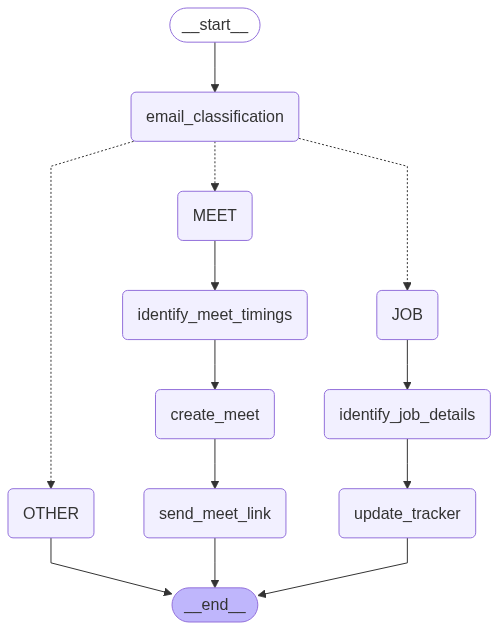

In [5]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("gone")
    pass

In [6]:
result = graph.invoke({"email": email1})
result['job_details']

---CLASSIFYING EMAIL---
['True', 'False', 'False']
Routing to: JOB
---IN JOB STATUS PATH---
This function reads the email to extract job title, company name and job status
This function updated the tracker with extracted job details


{'company_name': 'Liberty Mutual Insurance',
 'job_title': 'Analyst, Data Science',
 'job_id': '2025-71048',
 'application_status': 'applied'}

In [7]:
updates_df = pd.DataFrame(result['job_details'], index=[0])
updates_df

,company_name,job_title,job_id,application_status
0,Liberty Mutual Insurance,"Analyst, Data Science",2025-71048,applied


In [8]:
upsert_applications("test_tracker", updates_df)

               company_name              job_title      job_id  \
0  Liberty Mutual Insurance  Analyst, Data Science  2025-71048   

  application_status  
0            applied  
Updated tracker file at /Users/saideepbunny/Projects/Email-Assistant-using-Generative-AI/data/application_tracker.xlsx, sheet: test_tracker


In [9]:
result = graph.invoke({"email": email2})
result['job_details']

---CLASSIFYING EMAIL---
['True', 'False', 'False']
Routing to: JOB
---IN JOB STATUS PATH---
This function reads the email to extract job title, company name and job status
This function updated the tracker with extracted job details


{'company_name': 'Liberty Mutual Insurance',
 'job_title': 'Analyst, Data Science',
 'job_id': '2025-71048',
 'application_status': 'rejected'}

In [10]:
updates_df = pd.DataFrame(result['job_details'], index=[0])
updates_df

,company_name,job_title,job_id,application_status
0,Liberty Mutual Insurance,"Analyst, Data Science",2025-71048,rejected


In [11]:
upsert_applications("test_tracker", updates_df)

               company_name              job_title      job_id  \
0  Liberty Mutual Insurance  Analyst, Data Science  2025-71048   

  application_status  
0           rejected  
Updated tracker file at /Users/saideepbunny/Projects/Email-Assistant-using-Generative-AI/data/application_tracker.xlsx, sheet: test_tracker
